In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import streamlit as st

In [3]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [5]:
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [7]:
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 3854


In [9]:
df['smoking_history'] = df['smoking_history'].replace({'not current': 'former', 'ever': 'former', 'No Info': 'unknown'})

In [11]:
df = df[df['age'] >= 18]

In [13]:
df = df[(df['bmi'] >= 15) & (df['bmi'] <= 60)]  # Reasonable BMI range

In [15]:
# Check class balance
print(df['diabetes'].value_counts(normalize=True))

diabetes
0    0.898681
1    0.101319
Name: proportion, dtype: float64


In [17]:
# Basic statistics
print(df.describe())

                age  hypertension  heart_disease           bmi   HbA1c_level  \
count  82610.000000  82610.000000   82610.000000  82610.000000  82610.000000   
mean      48.859387      0.090207       0.047549     28.585311      5.549978   
std       18.017533      0.286480       0.212811      5.891322      1.086992   
min       18.000000      0.000000       0.000000     15.010000      3.500000   
25%       34.000000      0.000000       0.000000     25.560000      4.800000   
50%       49.000000      0.000000       0.000000     27.320000      5.800000   
75%       63.000000      0.000000       0.000000     30.630000      6.200000   
max       80.000000      1.000000       1.000000     60.000000      9.000000   

       blood_glucose_level      diabetes  
count         82610.000000  82610.000000  
mean            139.063418      0.101319  
std              41.762598      0.301753  
min              80.000000      0.000000  
25%             100.000000      0.000000  
50%             140.0

In [19]:
# Visualizations
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

Text(0.5, 1.0, 'Age Distribution by Diabetes Status')

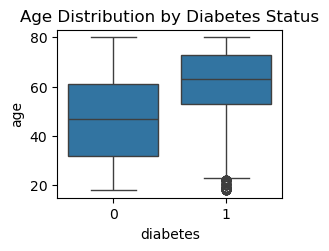

In [21]:
# Age distribution by diabetes status
plt.subplot(2, 2, 1)
sns.boxplot(x='diabetes', y='age', data=df)
plt.title('Age Distribution by Diabetes Status')

Text(0.5, 1.0, 'BMI Distribution by Diabetes Status')

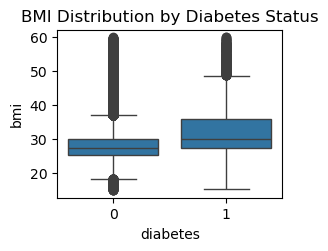

In [23]:
# BMI distribution by diabetes status
plt.subplot(2, 2, 2)
sns.boxplot(x='diabetes', y='bmi', data=df)
plt.title('BMI Distribution by Diabetes Status')

Text(0.5, 1.0, 'HbA1c Level by Diabetes Status')

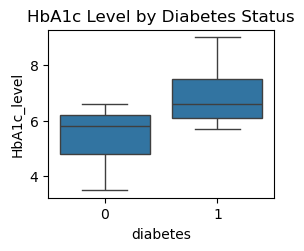

In [25]:
# HbA1c level by diabetes status
plt.subplot(2, 2, 3)
sns.boxplot(x='diabetes', y='HbA1c_level', data=df)
plt.title('HbA1c Level by Diabetes Status')

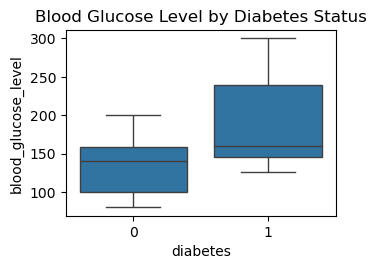

In [27]:
# Blood glucose level by diabetes status
plt.subplot(2, 2, 4)
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df)
plt.title('Blood Glucose Level by Diabetes Status')

plt.tight_layout()
plt.show()

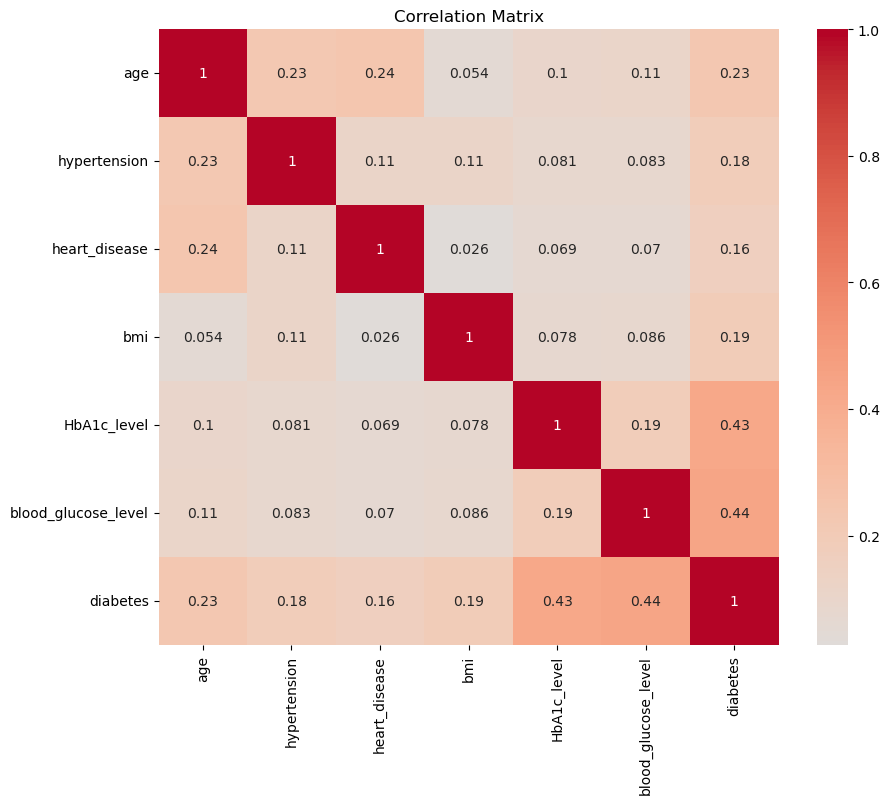

In [29]:
# Correlation matrix
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

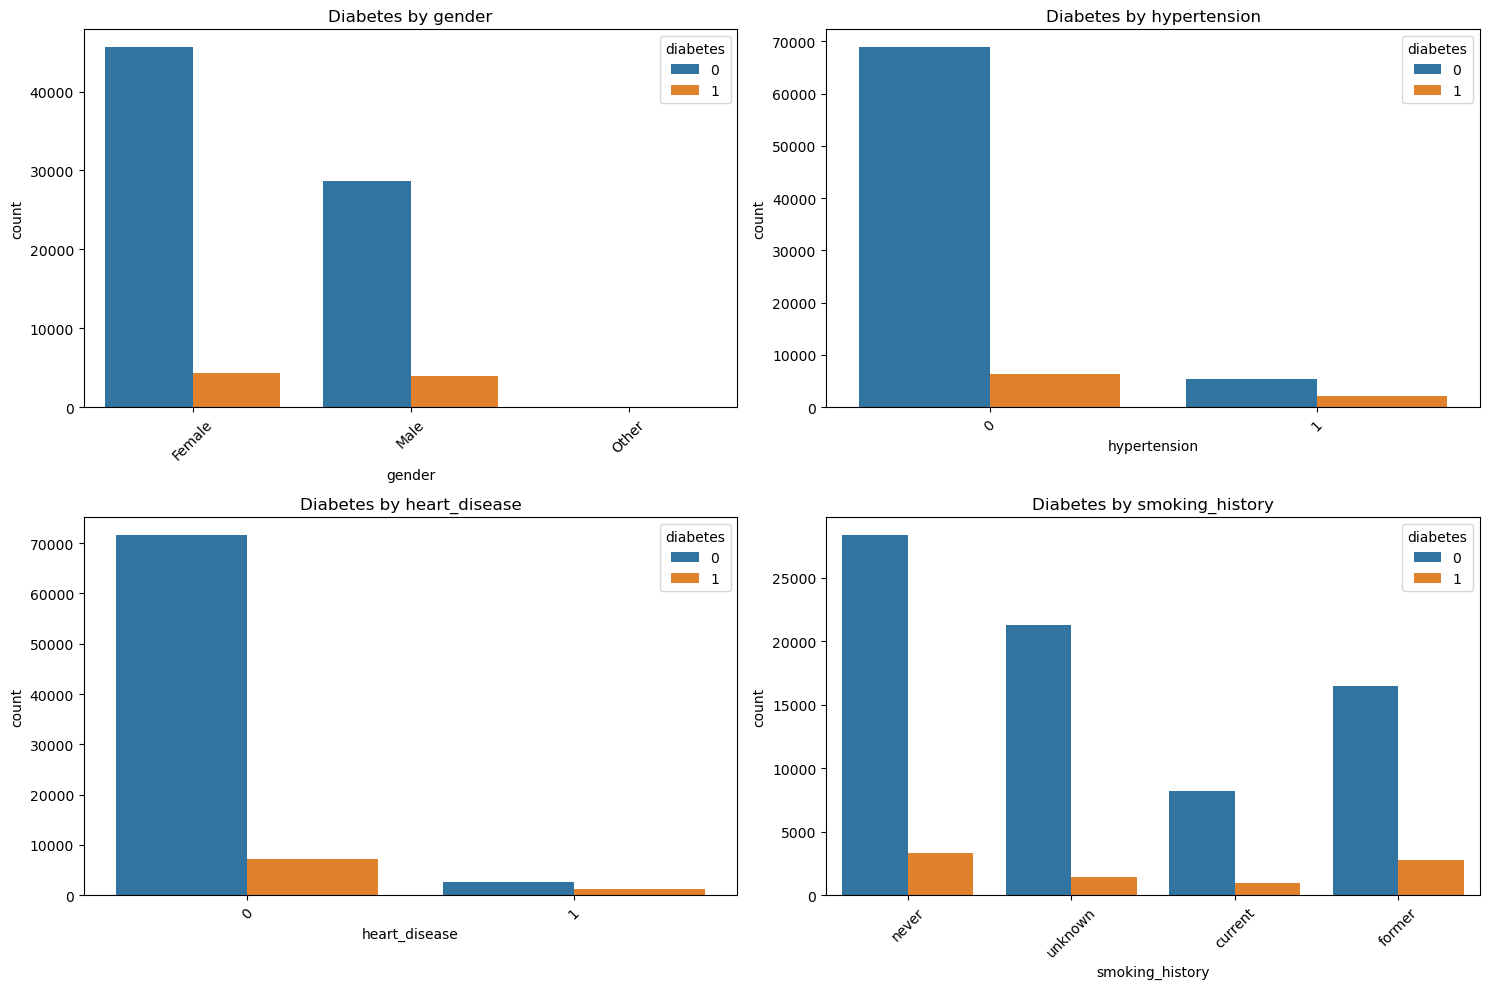

In [31]:
# Categorical variables analysis
cat_vars = ['gender', 'hypertension', 'heart_disease', 'smoking_history']

plt.figure(figsize=(15, 10))
for i, var in enumerate(cat_vars, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=var, hue='diabetes', data=df)
    plt.title(f'Diabetes by {var}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
# Create age groups
df['age_group'] = pd.cut(df['age'], 
                         bins=[18, 30, 45, 60, 80, 100],
                         labels=['18-29', '30-44', '45-59', '60-79', '80+'])

In [35]:
# Create BMI categories
df['bmi_category'] = pd.cut(df['bmi'],
                           bins=[0, 18.5, 25, 30, 35, 40, 100],
                           labels=['Underweight', 'Normal', 'Overweight', 
                                   'Obese I', 'Obese II', 'Obese III'])

In [37]:
# Create HbA1c categories
df['HbA1c_category'] = pd.cut(df['HbA1c_level'],
                             bins=[0, 5.7, 6.4, 100],
                             labels=['Normal', 'Prediabetes', 'Diabetes'])

In [39]:
# Create glucose categories
df['glucose_category'] = pd.cut(df['blood_glucose_level'],
                              bins=[0, 99, 125, 200, 300],
                              labels=['Normal', 'Prediabetes', 'Diabetes', 'Severe'])

In [41]:
# Define features and target
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define preprocessing for numeric and categorical features
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['gender', 'hypertension', 'heart_disease', 'smoking_history']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Get feature names after preprocessing
preprocessor.fit(X_train)

# For getting feature names later
def get_feature_names(column_transformer):
    output_features = []
    
    for name, pipe, features in column_transformer.transformers_:
        if name == 'remainder':
            continue
        if hasattr(pipe, 'get_feature_names_out'):
            names = pipe.get_feature_names_out(features)
        elif hasattr(pipe, 'get_feature_names'):
            names = pipe.get_feature_names(features)
        else:
            names = features
        output_features.extend(names)
            
    return output_features

feature_names = get_feature_names(preprocessor)

Logistic Regression: Mean ROC-AUC = 0.9567
Random Forest: Mean ROC-AUC = 0.9546
Gradient Boosting: Mean ROC-AUC = 0.9757
SVM: Mean ROC-AUC = 0.9402
KNN: Mean ROC-AUC = 0.9032
XGBoost: Mean ROC-AUC = 0.9731
                      ROC-AUC
Gradient Boosting    0.975675
XGBoost              0.973098
Logistic Regression  0.956731
Random Forest        0.954626
SVM                  0.940226
KNN                  0.903199


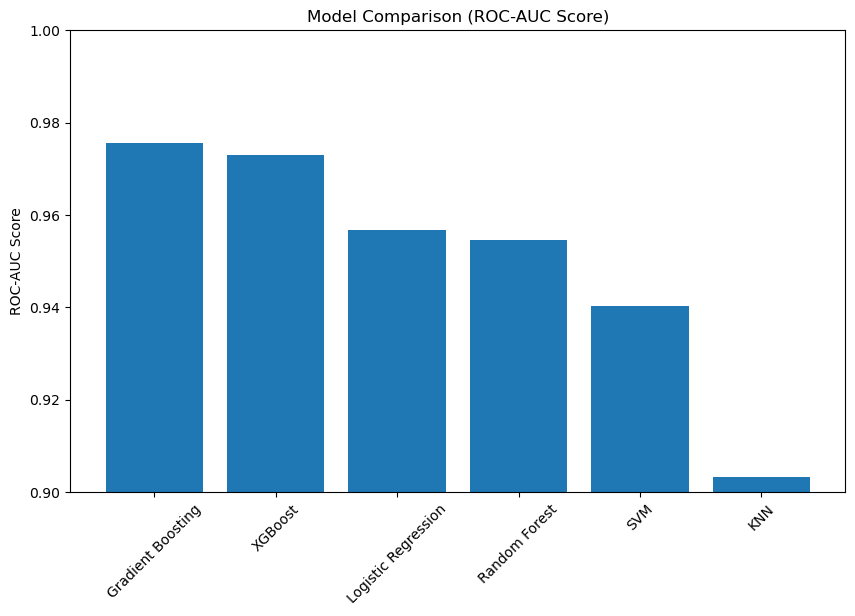

In [43]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Evaluate each model using cross-validation
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', model)])
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
    results[name] = cv_scores.mean()
    print(f"{name}: Mean ROC-AUC = {cv_scores.mean():.4f}")

# Display results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['ROC-AUC'])
results_df = results_df.sort_values(by='ROC-AUC', ascending=False)
print(results_df)

# Visualize model comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['ROC-AUC'])
plt.title('Model Comparison (ROC-AUC Score)')
plt.ylabel('ROC-AUC Score')
plt.xticks(rotation=45)
plt.ylim(0.9, 1.0)
plt.show()


Tuning Gradient Boosting...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\otien\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}
Best CV score (ROC-AUC): 0.9762

Test Set Performance:
Accuracy: 0.9665
Precision: 0.9738
Recall: 0.6876
F1 Score: 0.8060
ROC-AUC: 0.9745


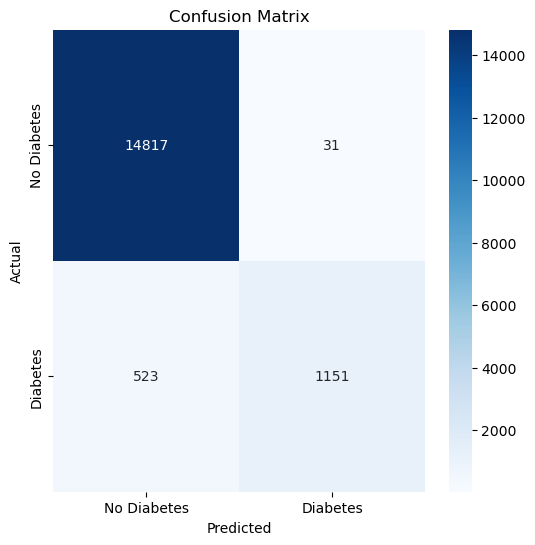


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     14848
           1       0.97      0.69      0.81      1674

    accuracy                           0.97     16522
   macro avg       0.97      0.84      0.89     16522
weighted avg       0.97      0.97      0.96     16522



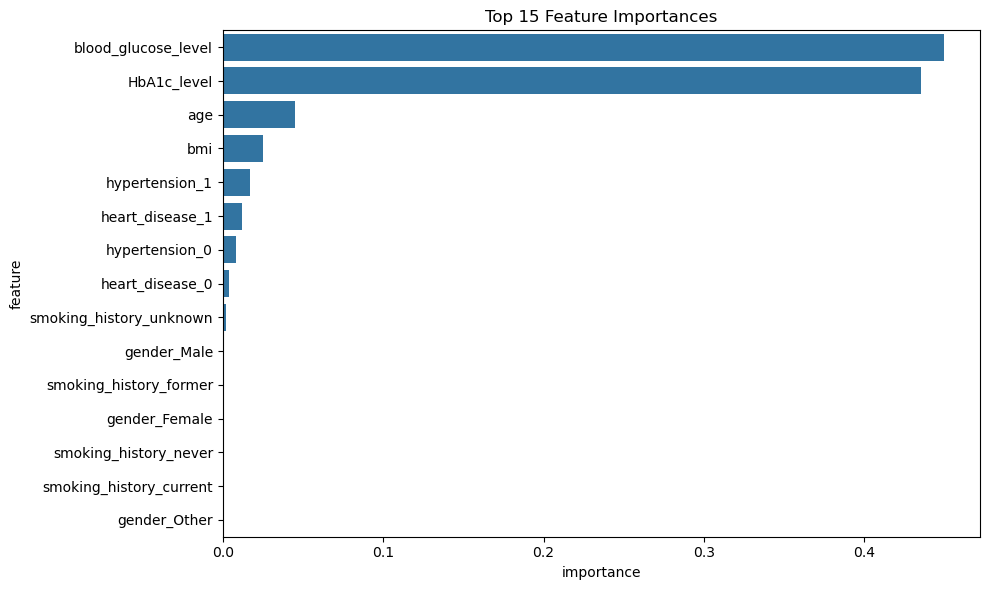

In [47]:
# Based on results, let's tune the best performing model
best_model_name = results_df.index[0]
print(f"\nTuning {best_model_name}...")

# Define pipeline with best model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', models[best_model_name])])

# Define parameter grids for each model type
if best_model_name == 'XGBoost':
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 4, 5],
        'classifier__subsample': [0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.8, 0.9, 1.0]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 4, 5],
        'classifier__subsample': [0.8, 0.9, 1.0],
        'classifier__max_features': ['sqrt', 'log2', None]
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['sqrt', 'log2', None]
    }
elif best_model_name == 'Logistic Regression':
    param_grid = {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    }
elif best_model_name == 'SVM':
    param_grid = {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    }
elif best_model_name == 'KNN':
    param_grid = {
        'classifier__n_neighbors': [3, 5, 7, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2]  # 1: manhattan, 2: euclidean
    }

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score (ROC-AUC): {grid_search.best_score_:.4f}")

# Evaluate on test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance (for tree-based models)
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    importances = best_model.named_steps['classifier'].feature_importances_
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()
    plt.show()

In [49]:
# Save the best model and preprocessor
joblib.dump(best_model, 'diabetes_risk_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

# Save feature names
import json
with open('feature_names.json', 'w') as f:
    json.dump(feature_names, f)